In [1]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import scipy.ndimage
import matplotlib.pyplot as plt
import pymc3 as pm
import math

In [2]:
tracks = pickle.load(open("mario_tracks.pkl"))

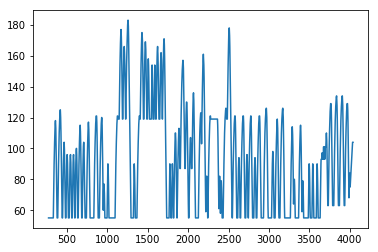

In [3]:

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for track in sorted(tracks[0]):
    trackID = track
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
plt.plot(track[:,0],256-track[:,2])
plt.show()
    

In [4]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 2
window = 3

velocities = track[1:,axis]-track[:-1,axis] 

thresholds(velocities)

{-8, -3, -2, -1, 0, 4, 8}

In [5]:
def samey_intervals(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        if ((t - last_diff_t) >= t_window) and v != last_diff:
            intervals.append(last_diff_t)
            intervals.append(t-1)
            intervals.append(t)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities

[0 0 0 ..., 0 0 0]


In [6]:
def zero_crossings(vals):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if last_sign == 0:
            last_sign = v
        elif v == 0 or v == last_sign:
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t-1)
            sign_intervals.append(t)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    return sign_intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)


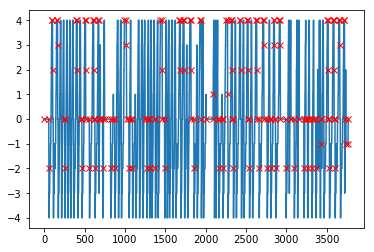

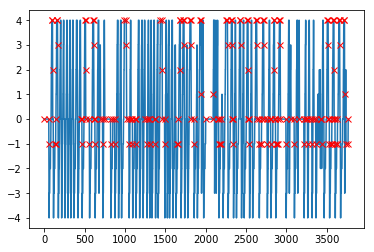

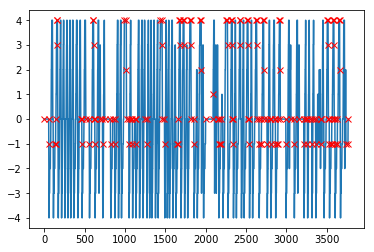

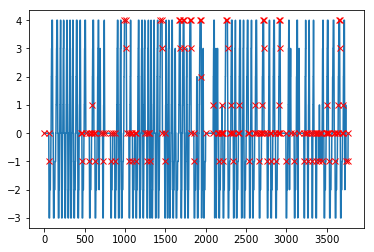

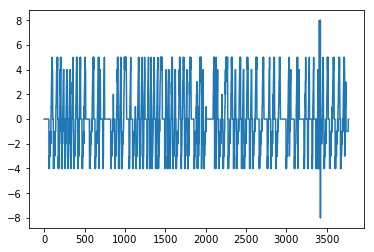

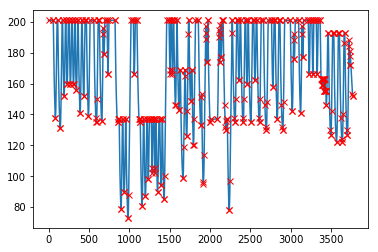

In [7]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 10

switch_points = set(zero_crossings(velocities))

smoothed_points = set(samey_intervals(velocities,t_window=same_window))
for w in range(2,6):
    smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(w)/w)
    #print smoothed
    plt.plot(smoothed)
    
    points = samey_intervals(smoothed,t_window=same_window)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    
    pts = set()
    for pt in smoothed_points:
        added = False
        for ii in range(-same_window,same_window+1):
            if pt+ii in points:
                pts.add(pt)
    
    for pt in points:
        add = True
        for ii in range(-same_window,same_window+1):
            if pt+ii in pts:
                add = False
        if add:
            pts.add(pt)
    
    smoothed_points = pts

velocity_times = sorted(switch_points |smoothed_points)

plt.plot(velocities)
plt.show()

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')
plt.show()


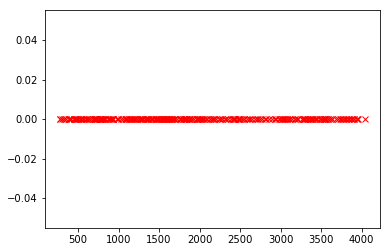

In [8]:
import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t)
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)

plt.plot(np.array(button_times),np.array(button_times)*0,'rx')
plt.show()

In [9]:
# Templates is an array of model-generating functions of increasing complexity.
templates = [
    # Constant 0 velocity
    ("c0",lambda n,axis,vs,pv: pm.Normal(
        n, 
        mu=0,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant velocity from old value
    ("cP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Fixed constant velocity
    ("cN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10),
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from 0
    ("acc0",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from old velocity value
    ("accP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv+pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from fixed constant velocity
    ("accN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10)+pm.Normal(n+"_acc",mu=0,sd=20)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
]
templates = templates
type2ind = {t[0]:i for i,t in enumerate(templates)}
print type2ind

{'accN': 5, 'cN': 2, 'acc0': 3, 'c0': 0, 'cP': 1, 'accP': 4}


In [10]:
iterations = 5000
def model_template_generate(template_i, axis, segment, prev_val):
    axisNames = [None,"x","y"]
    template = templates[template_i]
    (tn, t) = template
    with pm.Model() as model:
        lik = t(axisNames[axis],axis,segment,prev_val)
        step = pm.Metropolis()
        trace = pm.sample(iterations, step, progressbar=True)
        subtrace = trace[len(trace)/2:-1:10]
    return (tn,model,subtrace)

In [ ]:
def model_set_generate(data):
    track,all_times,axis,i,j = data
    t0 = all_times[i]
    t1 = all_times[j]
    print "go",i,j,t0,t1
    if t0 == 0:
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = float('inf')
    elif t1+1 > np.shape(track)[1]:
        extended_track = np.concatenate((track,[track[-1]]))
        segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    else:
        #9,10,11 - 8,9,10
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    segment[:,0] = range(0,np.shape(segment)[0])
    result = map(
        lambda ti: model_template_generate(ti, 
                                           axis,
                                           segment,
                                           prev_vel),
        range(0,len(templates)))
    return (i,j,t0,t1,result)

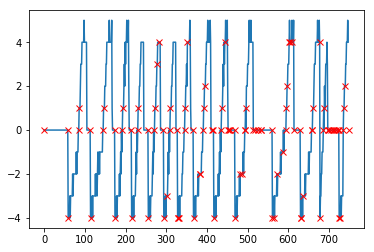

0
go 0 1 0 58


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '15745' (I am process '27824')
WARNING (theano.gof.cmodule): Deleting (broken cache directory [EOF]): /home/darkacloo/.theano/compiledir_Linux-4.2--generic-x86_64-with-Ubuntu-15.10-wily-x86_64-2.7.10-64/tmpCqi1WM
  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
%%time
iterations = 5000
all_times = sorted(set(velocity_times + button_times))

all_times = all_times[:100]#[:len(all_times)/4]
likes = [None]*len(all_times)

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

print "Done!"

In [ ]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

In [ ]:
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            #crit = pm.stats.dic(model=mod,trace=trace)
            #if np.abs(crit) > 1e5:
            #    crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            #crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            #error = summary["mean"]["y_err"]*dt
            here = crit + m_prev + cost
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)

map(lambda m:m[1],modes)

In [ ]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',p[1],'\n'

In [ ]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


In [ ]:
cross = {}
unions = UnionFind()

for ii,mode in enumerate(path):
    d = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}
    model,trace = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}[mode[1][4]]
    for jj,mode2 in enumerate(path):
        model2,trace2 = {t[0]:t[1:] for t in likes[mode2[1][0]][mode2[1][1]][4]}[mode2[1][4]]
        if mode2[1][4] == mode[1][4]:
            try:
                crit = -np.mean([model.logp(pt) for pt in trace2])#pm.stats.dic(model=model,trace=trace2)
            except:

                crit = float('inf')
        else:
            crit = float('inf')
        cross[(ii,jj)] = crit

In [ ]:
complexityWeight = 20
for d in sorted(cross):
    good = True
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])])
   
    if (joined < (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
merged = {}
for u in unions:
    print u, unions[u]
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print merged

In [ ]:
iterations = 50000

def model_sets_generate(ti,data):
    track,all_times,axis,i,j = data
    segments = []
    for ind in range(len(i)):
        t0 = all_times[i[ind]]
        t1 = all_times[j[ind]]
        if t0 == 0:
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = 0
        elif t1+1 > np.shape(track)[1]:
            extended_track = np.concatenate((track,[track[-1]]))
            segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        else:
            #9,10,11 - 8,9,10
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        segment[:,0] = range(0,np.shape(segment)[0])
        segments.append(segment)
    segment = np.vstack(segments)
    result = model_template_generate(ti, 
                                       axis,
                                       segment,
                                       prev_vel)
    return (i,j,t0,t1,result)

for m in merged:
    print ''
    if len(merged[m]) > 1:
        i_ = []
        j_ = []
        for t in merged[m]:
            mode = path[t]
            dat = likes[mode[1][0]][mode[1][1]]            
            ti = type2ind[mode[1][4]]
            i_.append(dat[0])
            j_.append(dat[1])
            
        result = model_sets_generate(ti,(track,all_times,axis,i_,j_))
        print pm.df_summary(result[4][2])

In [ ]:
colors = ['r','g','b','c','m','y','k',"#aa0000","#00aa00","#0000aa","#880000","#008800","#000088"]
merged2color = {m:i for i,m in enumerate(sorted(merged))}

for m in merged:
    for t in merged[m]:
        plt.plot(np.array(path[t][1][2:4]),np.array([merged2color[m], merged2color[m]])+5,colors[merged2color[m]])

plt.plot(track[:,2]*0.1-20)
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

In [ ]:
collisions = pickle.load(open('mario_collisions.pkl'))

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        if b != last_mask:
            b_ = int(b)
            buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if b_ & (1 << (7-ii)):
                    buttons.append(c)
            l_ = int(last_mask)
            last_buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if l_ & (1 << (7-ii)):
                    last_buttons.append(c)
            mask_times[t] = (last_buttons,buttons)
            last_mask = b
    
    return mask_times

button_times = button_changes(track[:,3])
for t in sorted(button_times):
    print t, button_times[t]

In [ ]:
start_time = 270
from_x_to_y = {}
to_y = {}
for t in range(1,len(path)):
        if t == 0:
            prev = -1
        else:
            prev = unions[t-1]
            
        start = path[t][1][2]
        
        if prev[]
        print t,prev,'->',unions[t], start
        if start in button_times:
            print 'button', button_times[start]
        
        if start+start_time in collisions:
            for c in collisions[start+start_time]:
                print '\t',c
        print ''